In [19]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans, DBSCAN
from sklearn.manifold import TSNE
from sklearn.neighbors import kneighbors_graph, KNeighborsClassifier, NearestNeighbors
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import AgglomerativeClustering, Birch
from sklearn.metrics import pairwise_distances

from pyclustering.cluster.clarans import clarans
from pyclustering.cluster.cure import cure
from pyclustering.utils import timedcall

In [20]:
# Load data
df = pd.read_csv('trajectories2.csv')

In [21]:
# STEP 2: Filter out stationary points
def is_stationary(traj, threshold=20.0):  # threshold is max distance allowed
    x = traj['x'].values
    y = traj['y'].values
    dist = np.sqrt((x.max() - x.min())**2 + (y.max() - y.min())**2)
    return dist < threshold

stationary_ids = []

for pid, group in df.groupby('point_id'):
    if is_stationary(group):
        stationary_ids.append(pid)

print(f"Removed {len(stationary_ids)} stationary point_ids.")

df_filtered = df[~df['point_id'].isin(stationary_ids)]

Removed 0 stationary point_ids.


In [22]:
# Step 3: Create direction-only trajectory vectors
trajectories = []
point_ids = []

for pid, group in df_filtered.groupby('point_id'):
    group_sorted = group.sort_values('frame')
    traj = group_sorted[['x', 'y']].values.flatten()
    if len(traj) < 10:
        continue  # skip very short ones
    traj_direction = traj - traj[0]  # shift so it starts from origin
    traj_normed = traj_direction / (np.linalg.norm(traj_direction) + 1e-6)  # normalize vector
    trajectories.append(traj_normed)
    point_ids.append(pid)

trajectories_np = np.vstack(trajectories)

In [23]:
# Step 4: Dimensionality reduction (optional)
pca = PCA(n_components=10)
traj_pca = pca.fit_transform(trajectories_np)

In [24]:
# Step 5: Clustering (KMeans)
labels_kmeans = KMeans(n_clusters=5, random_state=42).fit_predict(traj_pca)

# Step 6: DBSCAN
labels_dbscan = DBSCAN(eps=0.5, min_samples=2).fit_predict(traj_pca)

# Step 7: t-SNE + KMeans
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
tsne_embed = tsne.fit_transform(traj_pca)
labels_tsne = KMeans(n_clusters=5, random_state=42).fit_predict(tsne_embed)

# Step 8: Chameleon-like
knn_graph = kneighbors_graph(traj_pca, n_neighbors=10, mode='connectivity')
agglo = AgglomerativeClustering(n_clusters=5, connectivity=knn_graph)
labels_cham = agglo.fit_predict(traj_pca)

# Step 9: CLARANS
clarans_instance = clarans(traj_pca.tolist(), 5, 5, 4)
(ticks, _) = timedcall(clarans_instance.process)
clusters_clarans = clarans_instance.get_clusters()
labels_clarans = np.full(len(traj_pca), -1)
for cid, cluster in enumerate(clusters_clarans):
    for idx in cluster:
        labels_clarans[idx] = cid

# Step 10: CURE
cure_instance = cure(traj_pca.tolist(), number_cluster=5, number_represent_points=5, compression=0.5)
(ticks, _) = timedcall(cure_instance.process)
clusters_cure = cure_instance.get_clusters()
labels_cure = np.full(len(traj_pca), -1)
for cid, cluster in enumerate(clusters_cure):
    for idx in cluster:
        labels_cure[idx] = cid

# Step 11: BIRCH
labels_birch = Birch(n_clusters=5).fit_predict(traj_pca)

/home/ishita/.local/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/home/ishita/.local/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:325: UserWarning: the number of connected components of the connectivity matrix is 2 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/ishita/.local/lib/python3.12/site-packages/sklearn/cluster/_birch.py:727: ConvergenceWarning: Number of subclusters found (1) by BIRCH is less than (5). Decrease the threshold.
  warnings.warn(


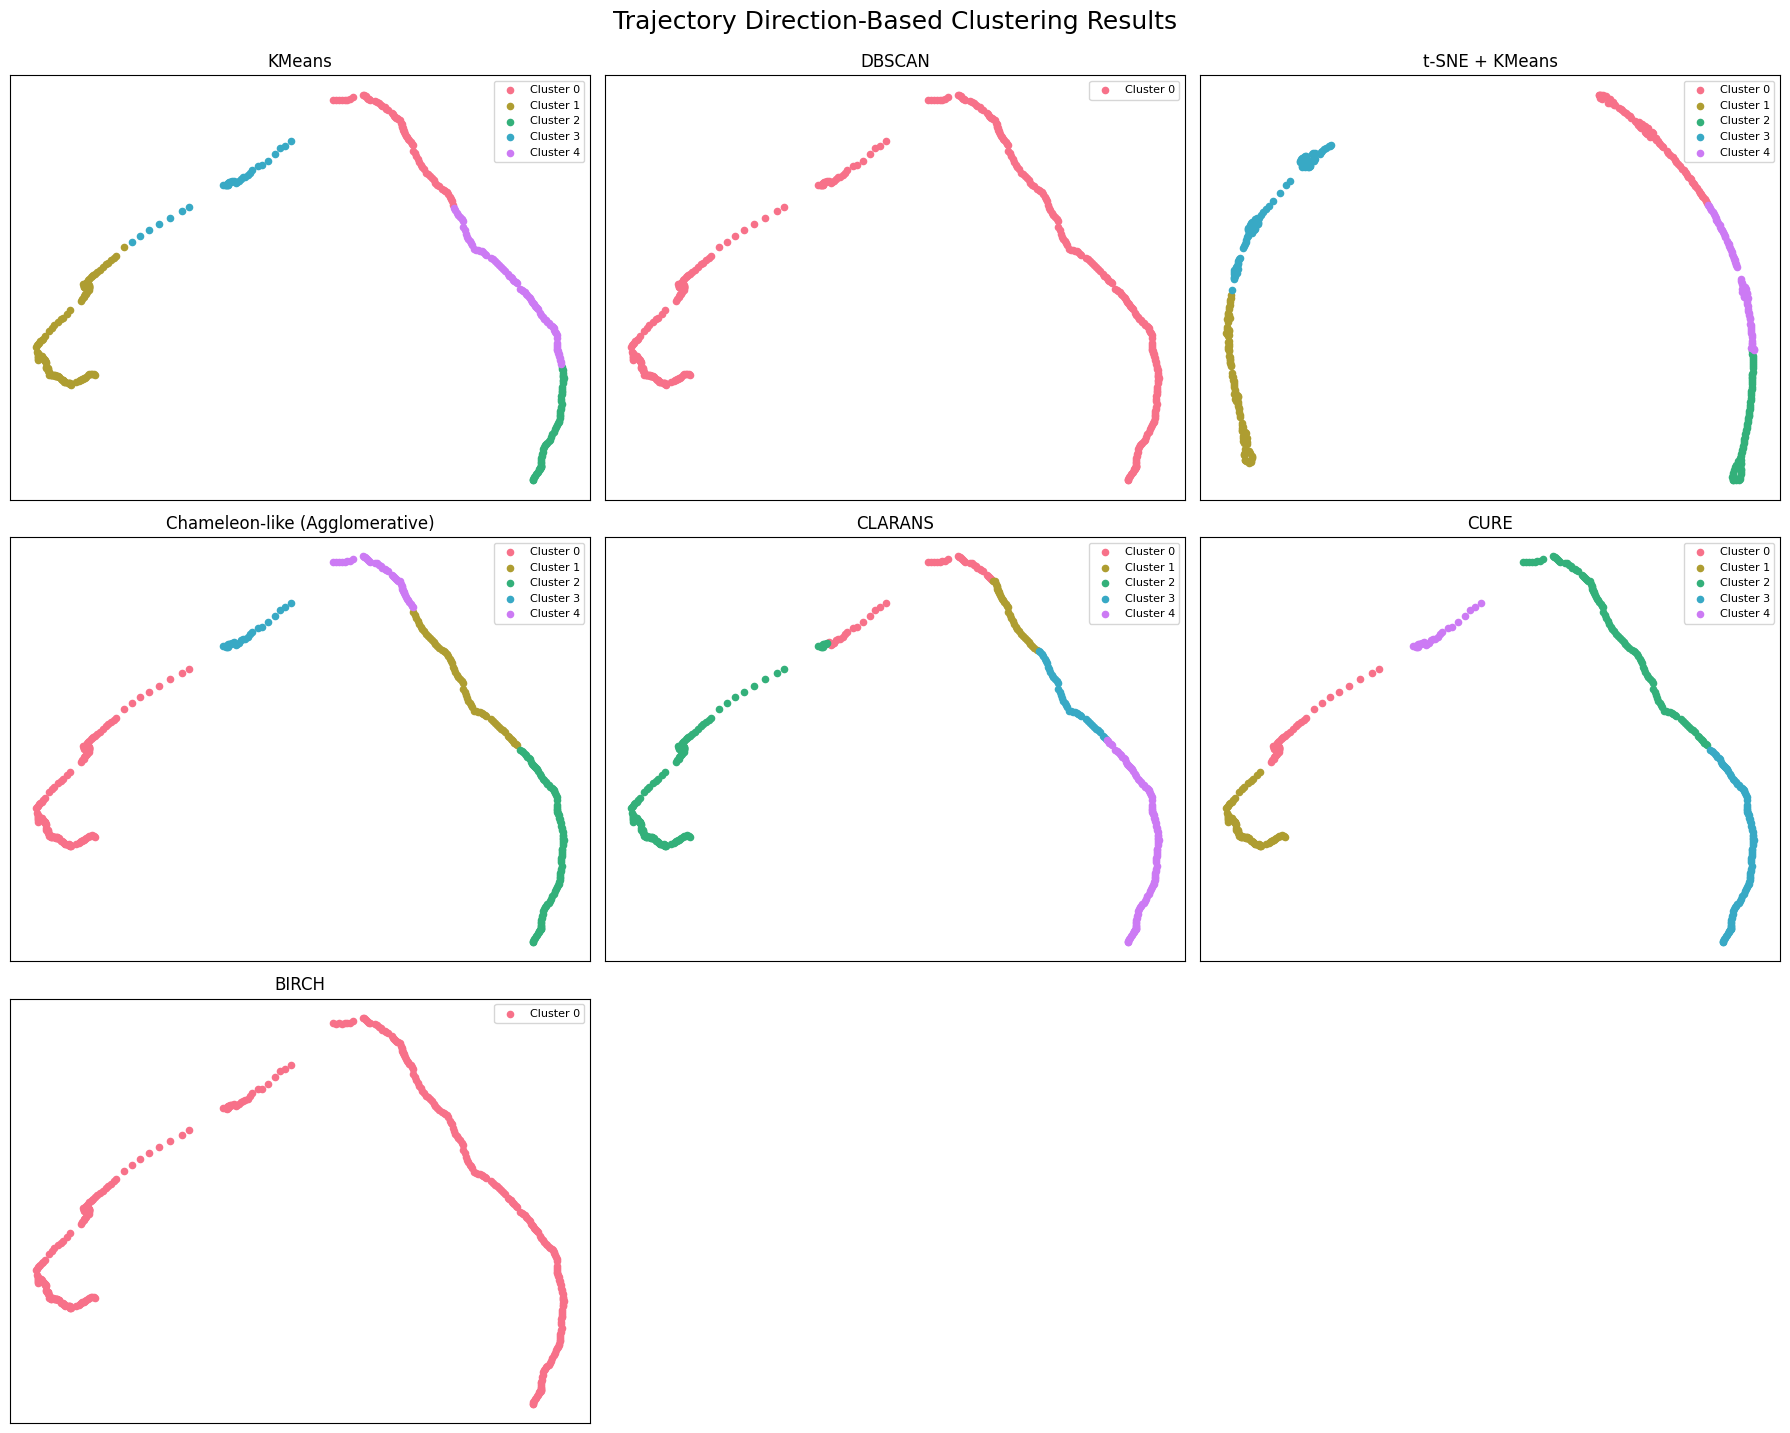

In [25]:
# List of all clustering results and titles
cluster_results = [
    ("KMeans", labels_kmeans),
    ("DBSCAN", labels_dbscan),
    ("t-SNE + KMeans", labels_tsne),
    ("Chameleon-like (Agglomerative)", labels_cham),
    ("CLARANS", labels_clarans),
    ("CURE", labels_cure),
    ("BIRCH", labels_birch),
]

# Optional: reduce to 2D for plotting if needed
embeddings = {
    "KMeans": PCA(n_components=2).fit_transform(traj_pca),
    "DBSCAN": PCA(n_components=2).fit_transform(traj_pca),
    "t-SNE + KMeans": tsne_embed,
    "Chameleon-like (Agglomerative)": PCA(n_components=2).fit_transform(traj_pca),
    "CLARANS": PCA(n_components=2).fit_transform(traj_pca),
    "CURE": PCA(n_components=2).fit_transform(traj_pca),
    "BIRCH": PCA(n_components=2).fit_transform(traj_pca),
}

# Plotting all in subplots
plt.figure(figsize=(18, 14))
for i, (title, labels) in enumerate(cluster_results):
    emb = embeddings[title]
    unique_labels = np.unique(labels)
    palette = sns.color_palette("husl", len(unique_labels))

    plt.subplot(3, 3, i + 1)
    for j, lbl in enumerate(unique_labels):
        idx = labels == lbl
        plt.scatter(emb[idx, 0], emb[idx, 1], s=20, label=f"Cluster {lbl}", color=palette[j])
    plt.title(title)
    plt.grid(True)
    plt.xticks([])
    plt.yticks([])
    plt.legend(fontsize=8)

plt.tight_layout()
plt.suptitle("Trajectory Direction-Based Clustering Results", fontsize=18, y=1.02)
plt.show()

/tmp/ipykernel_39926/1939504568.py:70: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('tab10')


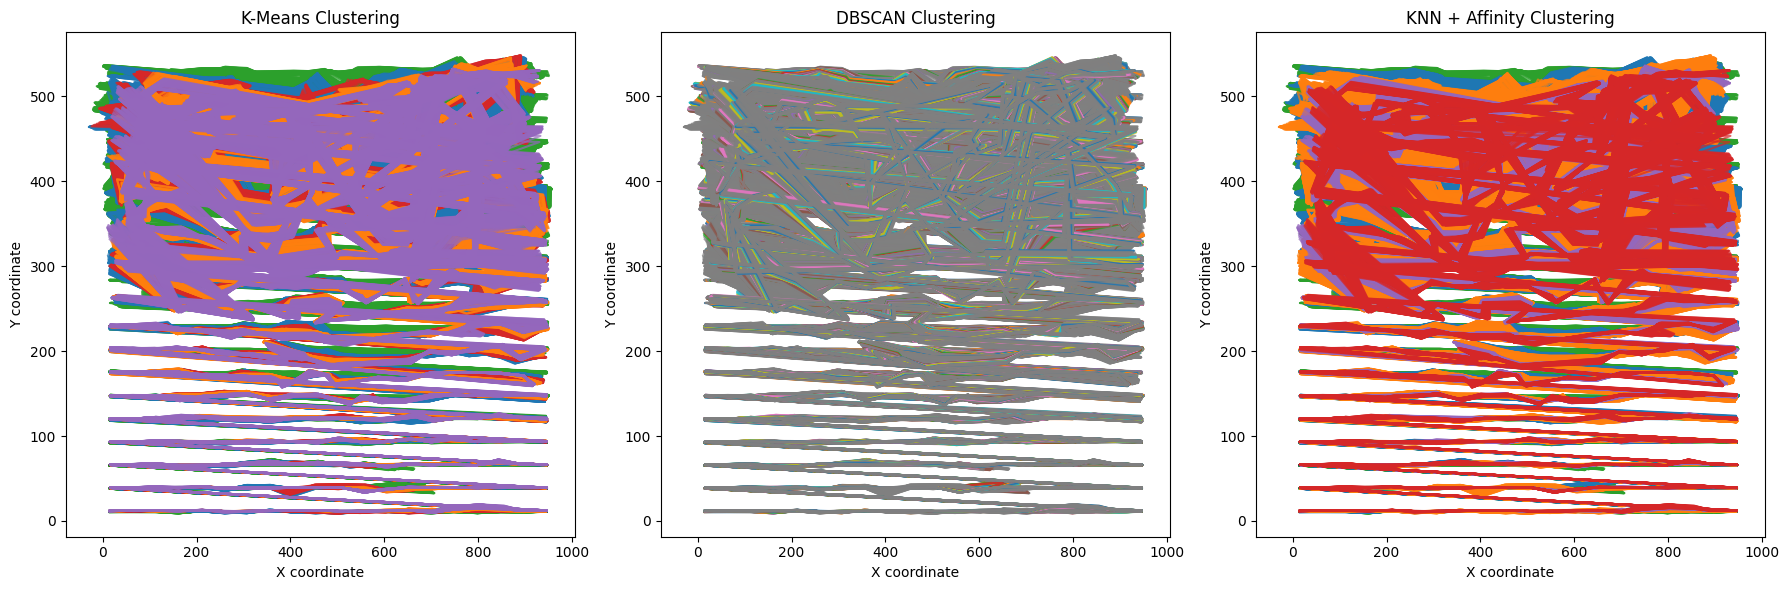

In [ ]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.decomposition import PCA
# from sklearn.manifold import TSNE
# from sklearn.cluster import KMeans, DBSCAN
# from sklearn.neighbors import NearestNeighbors
# from sklearn.preprocessing import StandardScaler
# from scipy.spatial.distance import pdist, squareform
# from sklearn.metrics import pairwise_distances
# from matplotlib.cm import get_cmap

# Load data
# df = pd.read_csv('trajectories2.csv')

# Step 1: Filter out stationary points
threshold = 5.0  # You can adjust this value
filtered_trajectories = []
unique_ids = df['point_id'].unique()

for pid in unique_ids:
    traj = df[df['point_id'] == pid].sort_values('frame')
    displacements = np.sqrt(np.diff(traj['x'])**2 + np.diff(traj['y'])**2)
    if np.sum(displacements) > threshold:
        filtered_trajectories.append(traj)

# Step 2: Convert to trajectory vectors
trajectory_vectors = []
valid_ids = []

for traj in filtered_trajectories:
    traj = traj.sort_values('frame')
    dx = np.diff(traj['x'])
    dy = np.diff(traj['y'])
    vector = np.concatenate((dx, dy))
    if len(vector) > 0:
        trajectory_vectors.append(vector)
        valid_ids.append(traj['point_id'].iloc[0])

# Pad vectors to the same length
max_len = max(len(v) for v in trajectory_vectors)
padded_vectors = np.array([np.pad(v, (0, max_len - len(v))) for v in trajectory_vectors])

# Feature Reduction for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(padded_vectors)

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(padded_vectors)

# KMeans
kmeans = KMeans(n_clusters=5, random_state=42)
labels_kmeans = kmeans.fit_predict(padded_vectors)

# DBSCAN
db = DBSCAN(eps=15, min_samples=2)
labels_dbscan = db.fit_predict(padded_vectors)

# KNN (using Nearest Neighbors + spectral affinity)
neighbors = NearestNeighbors(n_neighbors=5).fit(padded_vectors)
distances, indices = neighbors.kneighbors(padded_vectors)
affinity = np.exp(-pairwise_distances(padded_vectors) / padded_vectors.std())
knn_kmeans = KMeans(n_clusters=5, random_state=42)
labels_knn = knn_kmeans.fit_predict(affinity)

# Plotting actual trajectories colored by cluster labels
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
titles = ['K-Means Clustering', 'DBSCAN Clustering', 'KNN + Affinity Clustering']
label_sets = [labels_kmeans, labels_dbscan, labels_knn]
cmap = get_cmap('tab10')

for ax, labels, title in zip(axs, label_sets, titles):
    for i, traj in enumerate(filtered_trajectories):
        traj_sorted = traj.sort_values('frame')
        x = traj_sorted['x'].values
        y = traj_sorted['y'].values
        label = labels[i]
        if label == -1:
            color = 'gray'
        else:
            color = cmap(label % 10)
        ax.plot(x, y, color=color, alpha=0.7)
    ax.set_title(title)
    ax.set_xlabel('X coordinate')
    ax.set_ylabel('Y coordinate')

plt.tight_layout()
plt.show()
